In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu, ttest_ind

In [2]:
# Set display options
pd.set_option('display.max_columns', None)

In [3]:
# Load the processed data as pickle files to keep data types
data_processed = "../data/processed"
apps = pd.read_pickle(f"{data_processed}/applications.pkl")
company = pd.read_pickle(f"{data_processed}/company.pkl")
payments = pd.read_pickle(f"{data_processed}/payment.pkl")
df = pd.read_pickle(f"{data_processed}/merged.pkl")

In [4]:
company['external_credit_rating_label'].unique()

[NaN, 'Low Risk', 'Moderate Risk', 'Very Low Risk', 'High Risk']
Categories (4, object): ['Very Low Risk' < 'Low Risk' < 'Moderate Risk' < 'High Risk']

In [5]:
company.columns

Index(['company_id', 'incorporation_date', 'industry_segment',
       'working_capital', 'net_worth', 'legal_form', 'postcode_area',
       'type_of_external_credit_rating', 'external_credit_rating_label'],
      dtype='object')

In [6]:
print(df['industry_segment'].unique())
# Flag Construction segment
df['is_construction'] = df['industry_segment'] == 'Construct'

['Water', 'Construct', 'TransportStorage', 'unknown', 'WholesaleRetail', ..., 'InfoComm', 'FinancialInsurance', 'Mining', 'AgrFish', 'PublicAdminDefence']
Length: 20
Categories (20, object): ['AccommFood', 'Admin', 'AgrFish', 'ArtsRecr', ..., 'TransportStorage', 'Water', 'WholesaleRetail', 'unknown']


Looking at the characteristics of the **Construction segment** compared to other segments, we are interested in:
- whether there are any significant differences in  business characteristics?

In [7]:
# Create Flag for Construction sector
company['is_construction'] = company['industry_segment'] == 'Construct'

In [8]:
# Drop rows with missing type_of_external_credit_rating
company_copy = company.copy(deep=True)
rating_type_df = company_copy.dropna(subset=['type_of_external_credit_rating'])

# Create a cross-tabulation of counts
rating_type_counts = pd.crosstab(
    rating_type_df['type_of_external_credit_rating'],
    rating_type_df['is_construction'],
    rownames=['Type of External Credit Rating'],
    colnames=['Is Construction']
)

# Optional: Rename columns for clarity
rating_type_counts.columns = ['Non-Construction', 'Construction']

# Display the table
rating_type_counts

,Non-Construction,Construction
Type of External Credit Rating,,
Analysed - Non balancing,1,0
External credit risk,992,342
Non trading,1,0
Royal Charter Company,1,0
unknown,121,0


C:\Users\chloe\AppData\Local\Temp\ipykernel_28552\744377873.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp_label = rating_label_df.groupby(['is_construction', 'external_credit_rating_label']).size()


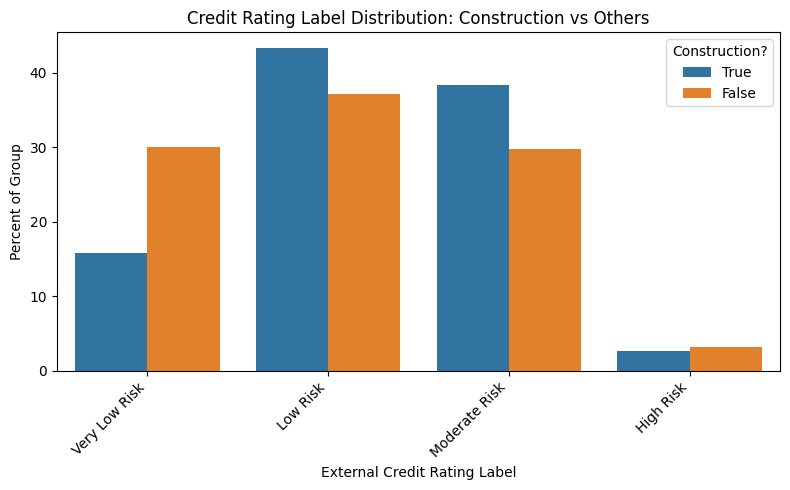

In [9]:
# Deep copy of company DataFrame
company_copy = company.copy(deep=True)

# --- External Credit Rating Label Analysis ---
# Drop rows with missing external credit rating labels
rating_label_df = company_copy.dropna(subset=['external_credit_rating_label'])

# Define the desired order
rating_order = [
    'Very Low Risk',
    'Low Risk',
    'Moderate Risk',
    'High Risk'
]

# Group and calculate percentages
grp_label = rating_label_df.groupby(['is_construction', 'external_credit_rating_label']).size()
pct_label = (
    grp_label
    .groupby(level=0)
    .apply(lambda s: 100 * s / s.sum())
    .droplevel(0)
    .rename('pct')
    .reset_index()
)

# Plot external_credit_rating_label
plt.figure(figsize=(8, 5))
sns.barplot(
    data=pct_label,
    x='external_credit_rating_label',
    y='pct',
    hue='is_construction',
    order=rating_order,
    hue_order=[True, False]
)
plt.xlabel('External Credit Rating Label')
plt.ylabel('Percent of Group')
plt.title('Credit Rating Label Distribution: Construction vs Others')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Construction?')
plt.tight_layout()
plt.show()


The graph above indicates that there may be a significant difference in the proportion of construction companies which fall into particular risk categories when compared to other industries. We now want to perform statistical analysis to assess whether these proportions are significant for each risk rating.

In [10]:
# Loop over each rating category
company_copy = company.copy(deep=True)
results = []
for rating in company_copy['external_credit_rating_label'].unique():
    # Create binary outcome for whether a company is in this rating
    company_copy['in_rating'] = company_copy['external_credit_rating_label'] == rating

    # Group counts for construction and non-construction
    k_constr = company_copy[(company_copy['is_construction']) & (company_copy['in_rating'])].shape[0]
    k_other  = company_copy[(~company_copy['is_construction']) & (company_copy['in_rating'])].shape[0]

    n_constr = company_copy[company_copy['is_construction']].shape[0]
    n_other  = company_copy[~company_copy['is_construction']].shape[0]

    # Z-test
    count = [k_constr, k_other]
    nobs = [n_constr, n_other]
    stat, pval = proportions_ztest(count, nobs)

    # Collect results
    results.append({
        'rating': rating,
        'construction_prop': k_constr / n_constr,
        'non_construction_prop': k_other / n_other,
        'z_stat': stat,
        'p_value': pval
    })

# Convert to DataFrame
import pandas as pd
results_company_copy = pd.DataFrame(results).sort_values(by='p_value')

# Display
results_company_copy


c:\Users\chloe\OneDrive\Documents\Job Hunt\Two Data Science Application\risk-assessment-data-science-case-study\risk-assessment-env\Lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


,rating,construction_prop,non_construction_prop,z_stat,p_value
2,Moderate Risk,0.383041,0.264337,4.223230,0.000024
3,Very Low Risk,0.157895,0.267025,-4.125918,0.000037
1,Low Risk,0.432749,0.329749,3.485045,0.000492
4,High Risk,0.026316,0.027778,-0.144810,0.884861
0,NaN,0.000000,0.000000,NaN,NaN


The results indicate that the proportion of construction companies which fall into the categories 'Very Low Risk', 'Low Risk' and 'Moderate Risk' are significantly different from other companies. The proportion of construction companies which fall into the category 'High Risk' is not picked up as a statistically significantly difference from other companies. 

We can see that:
1. There are **fewer** construction companies in the 'Very Low Risk' rating category compared to the other industries.
2. There are **more** construction companies in the 'Low Risk' and 'Moderate Risk' rating category compared to the other industries.

Analysis on the Net Worth and Working Capital for Construction vs other Industry Sectors

c:\Users\chloe\OneDrive\Documents\Job Hunt\Two Data Science Application\risk-assessment-data-science-case-study\risk-assessment-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\chloe\AppData\Local\Temp\ipykernel_28552\2285750419.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=company, y="industry_segment", x="log_working_capital", palette=palette, ax=axs[0])
C:\Users\chloe\AppData\Local\Temp\ipykernel_28552\2285750419.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=company, y="industry_segment", x="log_net_worth", palette=palette, ax=axs[1])


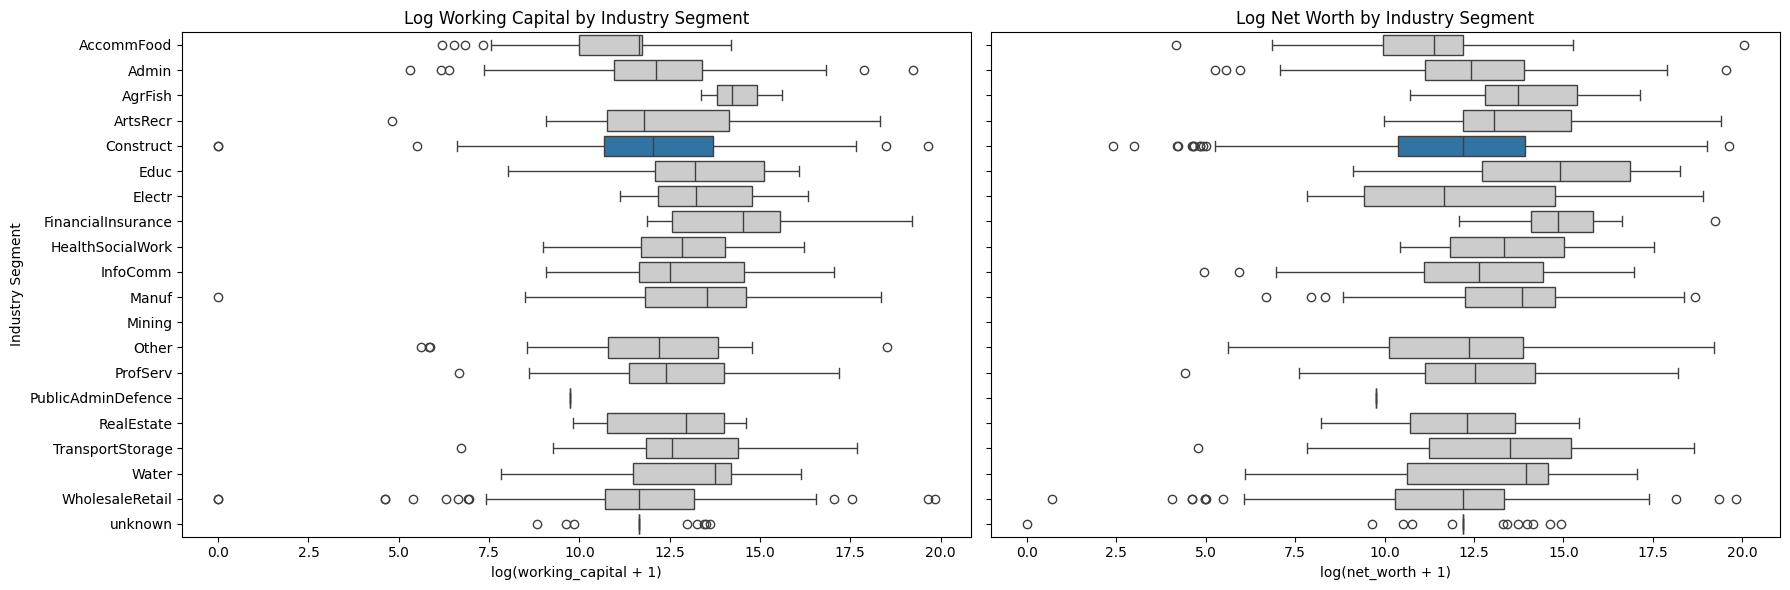

In [17]:

# Add log-transformed columns (adding 1 to avoid log(0))
company["log_working_capital"] = np.log1p(company["working_capital"])
company["log_net_worth"] = np.log1p(company["net_worth"])

# Define consistent color palette
industry_palette = company["industry_segment"].unique()
palette = {seg: ("#1f77b4" if seg == "Construct" else "#cccccc") for seg in industry_palette}

# Plot boxplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.boxplot(data=company, y="industry_segment", x="log_working_capital", palette=palette, ax=axs[0])
axs[0].set_title("Log Working Capital by Industry Segment")
axs[0].set_xlabel("log(working_capital + 1)")
axs[0].set_ylabel("Industry Segment")

sns.boxplot(data=company, y="industry_segment", x="log_net_worth", palette=palette, ax=axs[1])
axs[1].set_title("Log Net Worth by Industry Segment")
axs[1].set_xlabel("log(net_worth + 1)")
axs[1].set_ylabel("")

plt.tight_layout()
plt.show()

C:\Users\chloe\AppData\Local\Temp\ipykernel_28552\2813731104.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=company, x="segment_group", y="log_working_capital", palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"}, ax=axs[0])
C:\Users\chloe\AppData\Local\Temp\ipykernel_28552\2813731104.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=company, x="segment_group", y="log_net_worth", palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"}, ax=axs[1])


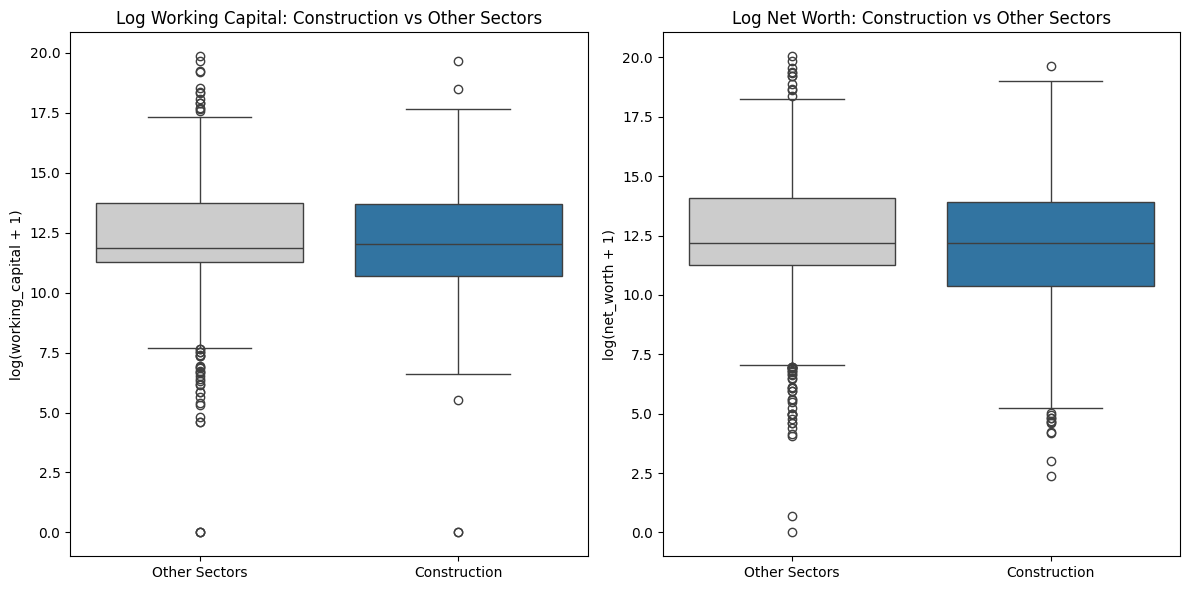

In [19]:
# Box plots for Construction vs Others
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=company, x="segment_group", y="log_working_capital", palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"}, ax=axs[0])
axs[0].set_title("Log Working Capital: Construction vs Other Sectors")
axs[0].set_ylabel("log(working_capital + 1)")
axs[0].set_xlabel("")

sns.boxplot(data=company, x="segment_group", y="log_net_worth", palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"}, ax=axs[1])
axs[1].set_title("Log Net Worth: Construction vs Other Sectors")
axs[1].set_ylabel("log(net_worth + 1)")
axs[1].set_xlabel("")

plt.tight_layout()
plt.show()

In [33]:

# Create log-transformed columns (adding 1 to avoid log(0))
company['log_net_worth'] = np.log1p(company['net_worth'])
company['log_working_capital'] = np.log1p(company['working_capital'])

# -------------------------
# 1) Net Worth
# -------------------------
raw_nw_constr = company.loc[company["is_construction"], "net_worth"].dropna()
raw_nw_others   = company.loc[~company["is_construction"], "net_worth"].dropna()

med_nw_constr = company.loc[company["is_construction"], "net_worth"].median()
med_nw_others = company.loc[~company["is_construction"], "net_worth"].median()

mw_raw_nw = mannwhitneyu(raw_nw_constr, raw_nw_others, alternative="two-sided")

print("=== Net Worth ===")
print(f"Median Net Worth [Construction]:     {med_nw_constr:.6f}")
print(f"Median Net Worth [Other Sectors]:    {med_nw_others:.6f}")
print(f"Mann–Whitney U on Net Worth: p =     {mw_raw_nw.pvalue:.6f}\n")

# -------------------------
# 2) Log(Net Worth) 
# -------------------------
log_nw_constr = company.loc[company["is_construction"], "log_net_worth"].dropna()
log_nw_others = company.loc[~company["is_construction"], "log_net_worth"].dropna()

med_log_nw_constr = log_nw_constr.median()
med_log_nw_others = log_nw_others.median()

mw_log_nw = mannwhitneyu(log_nw_constr, log_nw_others, alternative="two-sided")

print("=== Log(Net Worth) ===")
print(f"Median Log(Net Worth) [Construction]:     {med_log_nw_constr:.6f}")
print(f"Median Log(Net Worth) [Other Sectors]:    {med_log_nw_others:.6f}")
print(f"Mann–Whitney U on Log(Net Worth): p =     {mw_log_nw.pvalue:.6f}\n")

# -------------------------
# 3) Raw Working Capital
# -------------------------
raw_wc_constr = company.loc[company["is_construction"], "working_capital"].dropna()
raw_wc_others = company.loc[~company["is_construction"], "working_capital"].dropna()

med_wc_constr = raw_wc_constr.median()
med_wc_others = raw_wc_others.median()

mw_wc_raw = mannwhitneyu(raw_wc_constr, raw_wc_others, alternative="two-sided")

print("=== Raw Working Capital ===")
print(f"Median Working Capital [Construction]:     {med_wc_constr}")
print(f"Median Working Capital [Other Sectors]:    {med_wc_others}")
print(f"Mann–Whitney U on Raw Working Capital: p = {mw_wc_raw.pvalue:.6f}\n")

# -------------------------
# 4) Log(Working Capital)
# -------------------------
log_wc_constr = company.loc[company["is_construction"], "log_working_capital"].dropna()
log_wc_others = company.loc[~company["is_construction"], "log_working_capital"].dropna()

med_log_wc_constr = log_wc_constr.median()
med_log_wc_others = log_wc_others.median()

mw_wc_log = mannwhitneyu(log_wc_constr, log_wc_others, alternative="two-sided")

print("=== Log(Working Capital) ===")
print(f"Median Log(Working Capital) [Construction]:  {med_log_wc_constr:.6f}")
print(f"Median Log(Working Capital) [Other Sectors]: {med_log_wc_others:.6f}")
print(f"Mann–Whitney U on Log(Working Capital): p =  {mw_wc_log.pvalue:.6f}")


=== Net Worth ===
Median Net Worth [Construction]:     175048.500000
Median Net Worth [Other Sectors]:    194692.000000
Mann–Whitney U on Net Worth: p =     0.179066

=== Log(Net Worth) ===
Median Log(Net Worth) [Construction]:     12.179179
Median Log(Net Worth) [Other Sectors]:    12.179179
Mann–Whitney U on Log(Net Worth): p =     0.001457

=== Raw Working Capital ===
Median Working Capital [Construction]:     114254.0
Median Working Capital [Other Sectors]:    114254.0
Mann–Whitney U on Raw Working Capital: p = 0.339899

=== Log(Working Capital) ===
Median Log(Working Capital) [Construction]:  12.043048
Median Log(Working Capital) [Other Sectors]: 11.861312
Mann–Whitney U on Log(Working Capital): p =  0.405476


c:\Users\chloe\OneDrive\Documents\Job Hunt\Two Data Science Application\risk-assessment-data-science-case-study\risk-assessment-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


### 📊 Net Worth

- **Median (raw)**  
  - Construction: £175,049  
  - Other sectors: £194,692  
  - **Mann–Whitney U p-value**: 0.179 → *Not significant*

- **Median (log)**  
  - Construction: 12.18  
  - Other sectors: 12.18  
  - **Mann–Whitney U p-value**: 0.0015 → ✅ *Statistically significant*

While the **log-transformed medians** are the same, the **distributions differ significantly**. This indicates that Construction firms may have more variation—some with very high or very low net worth—even if the central value is similar. This difference in distribution shape (not center) is picked up by the Mann–Whitney U test.

---

### 📊 Working Capital

- **Median (raw)**  
  - Construction: £114,254  
  - Other sectors: £114,254  
  - **Mann–Whitney U p-value**: 0.340 → *Not significant*

- **Median (log)**  
  - Construction: 12.04  
  - Other sectors: 11.86  
  - **Mann–Whitney U p-value**: 0.405 → *Not significant*

Working capital distributions appear broadly similar between Construction and other sectors, both in scale and spread.

---

## 🧠 Interpretation and Next Steps

### Why Log Transforms Matter

Log transformations reduce skew and emphasize **relative differences** instead of **absolute pound values**. The fact that net worth shows a statistically significant difference *only* after log transformation suggests that:

- **Construction firms differ more in scale (ratio terms)** than in raw cash terms.
- The **variation** among Construction firms is relevant to credit risk—some are much larger or smaller than others.

This makes log-transformed net worth a potentially more informative feature for risk modeling.

---

### How This Informs Risk Profiling

- The **Construction sector exhibits higher dispersion** in net worth than other sectors, despite identical medians.
- This justifies:
  - Including **log(net_worth)** in modeling as a key feature.
  - Considering **sector segmentation** (e.g., training separate models or tuning thresholds for Construction firms).
  - Exploring **interactions** between financial variables and sector labels.

---

### ✅ Suggested Next Steps

1. **Visualize log(net_worth)** distributions for Construction vs. other sectors to communicate the spread.
2. Run **clustering** within Construction to identify financially high-risk vs. low-risk subgroups.
3. Add **interaction terms** like `is_construction × log(net_worth)` to future models.
4. Investigate if Construction companies differ in **age** or **temporal financial stability** (e.g., using `incorporation_date`).


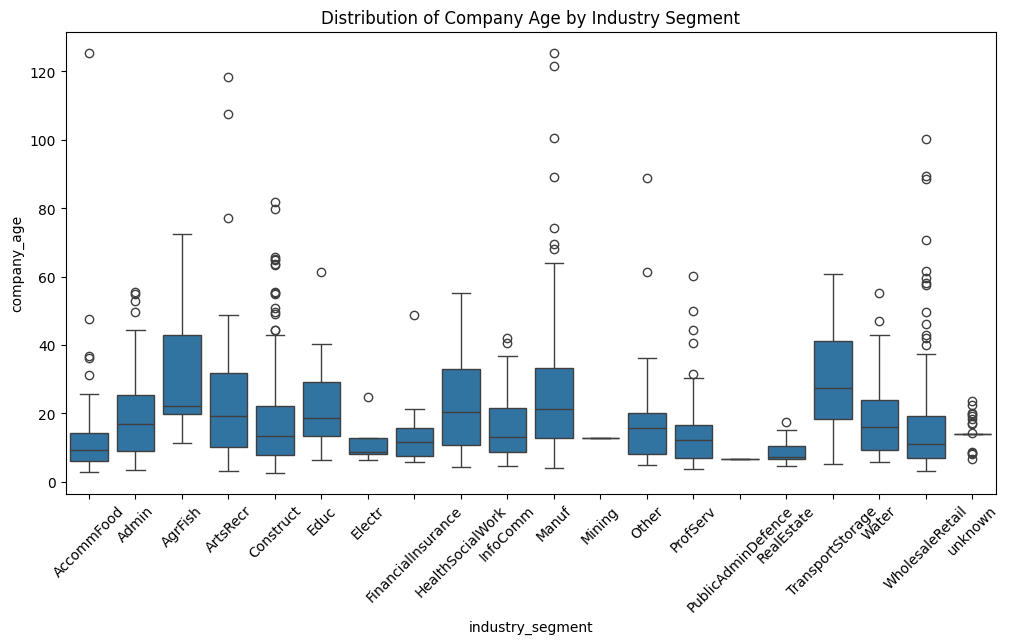

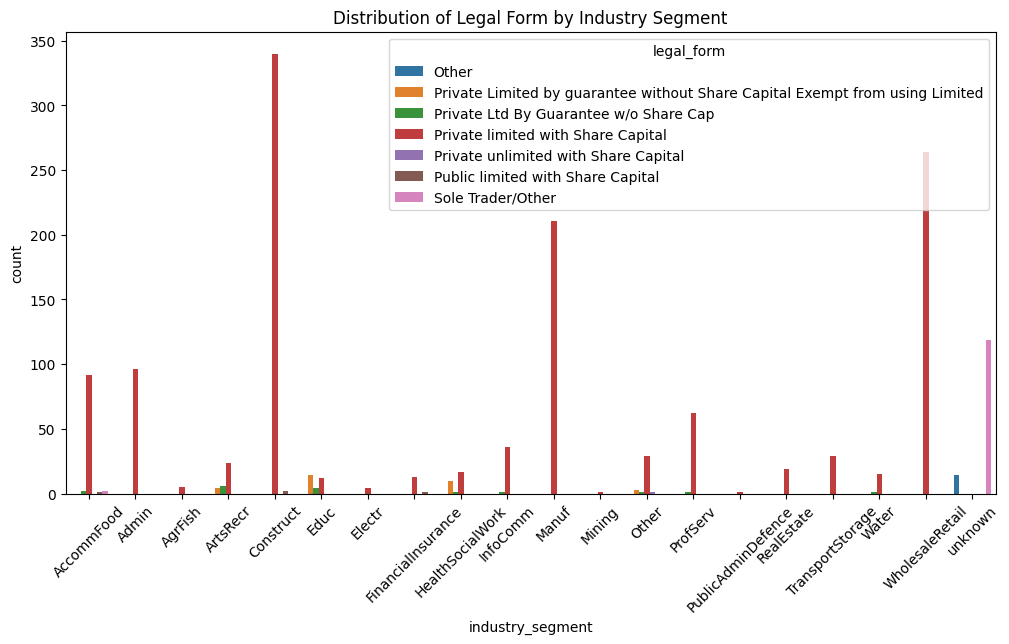

In [34]:
# 1. Calculate company age
company_copy = company.copy(deep=True)
from datetime import datetime
company_copy['incorporation_date'] = pd.to_datetime(company_copy['incorporation_date'])
company_copy['company_age'] = (datetime.now() - company_copy['incorporation_date']).dt.days / 365

# Boxplot for company age by industry_segment
plt.figure(figsize=(12,6))
sns.boxplot(x='industry_segment', y='company_age', data=company_copy)
plt.xticks(rotation=45)
plt.title('Distribution of Company Age by Industry Segment')
plt.show()

# 2. Grouped bar chart for legal_form by industry_segment
plt.figure(figsize=(12,6))
sns.countplot(x='industry_segment', hue='legal_form', data=company_copy)
plt.xticks(rotation=45)
plt.title('Distribution of Legal Form by Industry Segment')
plt.show()

C:\Users\chloe\AppData\Local\Temp\ipykernel_28552\3035355573.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=company_copy, x="segment_group", y="company_age", palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"})


AttributeError: 'Figure' object has no attribute 'set_title'

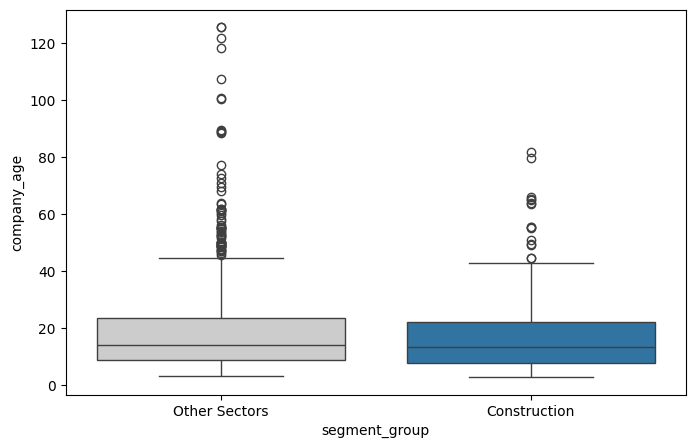

In [52]:
# Box plots for Construction vs Others
# plt.figure(figsize=(12,6))

# sns.boxplot(data=company_copy, x="segment_group", y="company_age", palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"}, ax=axs[0])
# axs[0].set_title("Company Age: Construction vs Other Sectors")
# axs[0].set_ylabel("Company Age")
# axs[0].set_xlabel("")

# Box plots for Construction vs Others
fig = plt.figure(figsize=(8, 5))

sns.boxplot(data=company_copy, x="segment_group", y="company_age", palette={"Construction": "#1f77b4", "Other Sectors": "#cccccc"})
fig.set_title("Log Working Capital: Construction vs Other Sectors")
fig.set_ylabel("log(working_capital + 1)")
fig.set_xlabel("")

plt.tight_layout()
plt.show()

In [55]:
# 2. Select numeric features for comparison
num_features = [
    'invoice_amount_clean',
    'days_past_due',
    'risk_score'
]

# 3. Compute summary statistics by segment
print("### Summary Statistics (Construction vs Others)")
display(df.groupby('is_construction')[num_features] \
                  .agg(['mean', 'median', 'std', 'count']))

### Summary Statistics (Construction vs Others)


invoice_amount_clean                           days_past_due  \
                                mean median          std count          mean   
is_construction                                                                
False                    1259.967623  435.0  2745.343460  3243      7.177647   
True                     1452.247028  672.0  3210.020271   757      6.627019   

                                        risk_score                         
                median        std count       mean median       std count  
is_construction                                                            
False              2.0  32.993291  3051   4.788063   3.26  4.903281  3243  
True               3.0  25.494788   681   5.025244   3.26  5.188669   757

## Testing Difference in Default Rates: Construction vs. Other Industries
> Is the default rate in the Construction segment different from the default rate in all other segments?

### Hypotheses

- **Null hypothesis (H₀):**  
  $$
  p_{C} \le p_{O}
  $$  
  The default proportion in Construction is less than or equal to that in Other industries.

- **Alternative hypothesis (H₁):**  
  $$
  p_{C} > p_{O}
  $$  
  The default proportion in Construction is greater than that in Other industries.

### When to Use a Two-Proportion Z-Test

- You have **two independent groups**:  
  1. Construction firms  
  2. All other firms
- You observe a **binary outcome** in each group: default (`True`) or no default (`False`).
- You wish to test whether the underlying population proportions $p_C$ and $p_O$ are equal.


### Test Statistic

1. **Sample proportions**  
   $$
   \hat p_C = \frac{k_C}{n_C}, 
   \quad
   \hat p_O = \frac{k_O}{n_O}
   $$  
   where  
   - $k_C$, $k_O$ are the number of defaults in Construction and Other groups  
   - $n_C$, $n_O$ are the total observations in each group  

2. **Pooled proportion**  
   $$
   \hat p = \frac{k_C + k_O}{n_C + n_O}
   $$

3. **Z-statistic**  
   $$
   Z
   = \frac{\hat p_C - \hat p_O}
          {\sqrt{\hat p \,(1 - \hat p)\,\bigl(\tfrac{1}{n_C} + \tfrac{1}{n_O}\bigr)}}
   $$

### Assumptions

1. **Independence** of observations within and between groups.  
2. **Sample sizes** large enough for normal approximation:  
   $n_C \hat p \ge 5,\; n_C(1-\hat p)\ge 5$, and similarly for $n_O$.

### Interpretation

- If **p-value < 0.05**, conclude that Construction firms have a **significantly higher** default rate than other industries at the 5% level.  
- If **p-value ≥ 0.05**, there is insufficient evidence to claim Construction’s default rate is higher.    

In [56]:
# 1. Total bills in each group
n_constr = df[df['is_construction']].shape[0]   # e.g., 757
n_other  = df[~df['is_construction']].shape[0]  # e.g., 3243

# 2. Number of defaults in each group
k_constr = df[(df['is_construction']) & (df['default_status'])].shape[0]
k_other  = df[(~df['is_construction']) & (df['default_status'])].shape[0]

print(f"Construction: {k_constr}/{n_constr} defaults  → rate = {k_constr/n_constr:.3%}")
print(f"Other segs : {k_other}/{n_other} defaults  → rate = {k_other/n_other:.3%}\n")

# 3. One‐sided two‐proportion Z-test (testing p_constr > p_other)
counts = [k_constr, k_other]
nobs   = [n_constr, n_other]

stat, pval_one_sided = proportions_ztest(
    count=counts,
    nobs=nobs,
    alternative='larger'   # one-sided: tests p1 > p2
)

print(f"Z-statistic       = {stat:.5f}")
print(f"One‐sided p-value = {pval_one_sided:.5f}")

# 4. Interpret at α = 0.05
alpha = 0.05
if pval_one_sided < alpha:
    print(f"→ Reject H₀: Construction’s default rate is significantly higher (p < {alpha}).")
else:
    print(f"→ Fail to reject H₀: No evidence that Construction’s default rate is higher (p ≥ {alpha}).")

Construction: 52/757 defaults  → rate = 6.869%
Other segs : 122/3243 defaults  → rate = 3.762%

Z-statistic       = 3.77384
One‐sided p-value = 0.00008
→ Reject H₀: Construction’s default rate is significantly higher (p < 0.05).


In [ ]:
df.head()

## To Do as part of Task 1.2:

1. calculate the number and % of:
- On time payments
- Late but not defaulted payments
- Defaulted on-time payments 

for the construction sector vs others

2. From the late payments, what is the average number of days past the due date for construction vs other sectors and is this significant?
3. Make a visualisation showing the size of the requested amounts for the construction company vs others and highlight the defaulted payments.
4. Visualize the Payment Timeliness Distribution


## To Do as part of Task 1.3:

1. id features correlated with default status
can use a random forest for feature importance






# Task 2

Q: does the risk score assigned to the construction companies reflect their default risk

Q: Are the defaulting construction companies consistent? I.e. is it always the same companies making the defaults? Is there anything they have in common? Can we cluster them and in order to generate more reflective risk scores for such a varies sector?

Q: how significant are the defaulted amounts compared to other segments? Are they big/small etc?
